In [1]:
import numpy as np
import datetime
import netCDF4
import xarray as xr
import cartopy, cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
# Open a GOES-16 image using xarray
goes = netCDF4.Dataset('OR_ABI-L1b-RadC-M6C02_G16_s20193251601159_e20193251603532_c20193251604001.nc', 'r')
store = xr.backends.NetCDF4DataStore(goes)
ds = xr.open_dataset(store)

In [3]:
# Get the information needed for the projection
p = ds['goes_imager_projection']
print(p)

# Projection x, y coordinates--> scanning angle (radians) * sat height
x = ds['x'][:] * p.perspective_point_height
y = ds['y'][:] * p.perspective_point_height

<xarray.DataArray 'goes_imager_projection' ()>
array(-2147483647)
Coordinates:
    t        datetime64[ns] ...
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    sweep_angle_axis:                x


In [4]:
# Create geostationary projection map object
globe = ccrs.Globe(semimajor_axis=p.semi_major_axis,
                       semiminor_axis=p.semi_minor_axis,
                       inverse_flattening=p.inverse_flattening)
geos = ccrs.Geostationary(central_longitude=p.longitude_of_projection_origin, 
                              satellite_height=p.perspective_point_height,
                              sweep_axis=p.sweep_angle_axis,
                              globe=globe)

In [5]:
# Transform current image projection coordinates (x,y) to lat, lon values
X, Y = np.meshgrid(x,y)
a = ccrs.PlateCarree().transform_points(geos, X, Y)
lons, lats = a[:,:,0], a[:,:,1]

In [6]:
# Create an xarray dataset with the lats, lons
latlon = xr.Dataset(dict(latitude=(('y', 'x'), lats), 
                     longitude=(('y', 'x'), lons)))
latlon.latitude.attrs = dict(standard_name='latitude', long_name='latitude', units='degrees_north')
latlon.longitude.attrs = dict(standard_name='longitude', long_name='longitude', units='degrees_east')
latlon.coords['latitude'] = latlon.latitude
latlon.coords['longitude'] = latlon.longitude

#name = f'./LatLon_GOES16_CONUS_0.5km.nc'
#latlon.to_netcdf(name)
#latlon16 = xr.open_dataset("LatLon_GOES16_CONUS_0.5km.nc")

In [7]:
# Merge the two datasets
ds = xr.merge([ds, latlon])

In [8]:
# Latitude and longitude of the ARM SGP central facility
sgp_lon = -97.487643
sgp_lat = 36.607322

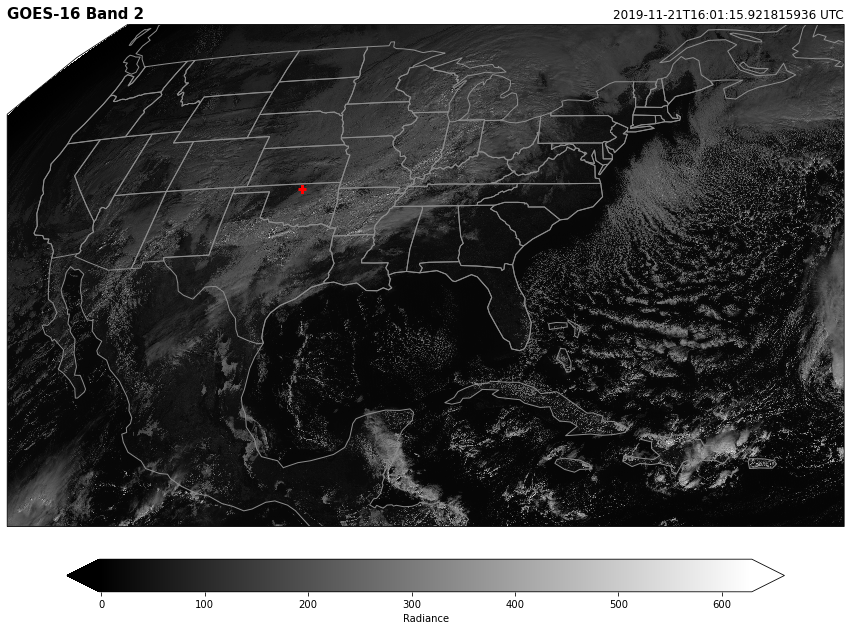

In [9]:
# Radiance plot with geostationary projection
rad = ds.variables['Rad'][:]

fig = plt.figure(figsize=(15, 12))

ax = fig.add_subplot(1, 1, 1, projection=geos)

# Plot the image
img = ax.imshow(rad, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='nearest', cmap='gray')

# Get scan start time
scan_start = ds['time_bounds'][0].values

# Get ABI band number
ABI_band = ds['band_id'][0].values

# Plot title
plt.title('GOES-16 Band {}'.format(ABI_band), loc='left', fontweight='bold', fontsize=15)
plt.title('{} UTC'.format(scan_start), loc='right')
plt.colorbar(img, label='Radiance', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

# Plot location of ARM SGP Central Facility
ax.scatter(sgp_lon, sgp_lat, transform=ccrs.PlateCarree(), marker='+', s=75, c='red', linewidth=3)

# Add state borders and coastlines
ax.coastlines(resolution='110m', color='0.55', linewidth=1)
ax.add_feature(ccrs.cartopy.feature.STATES.with_scale('110m'), edgecolor='0.55')

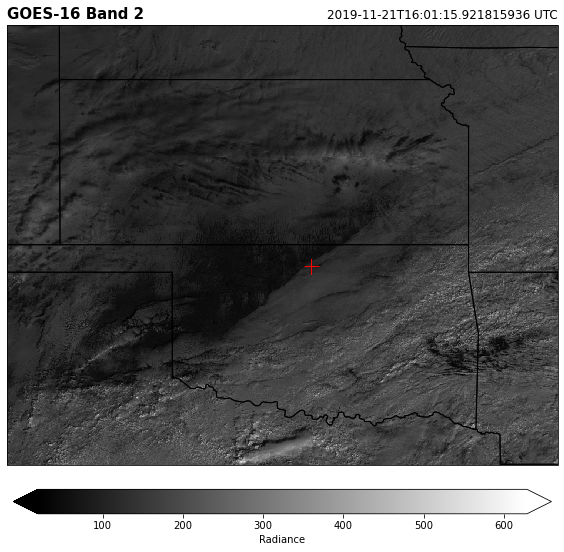

In [10]:
# Zoomed in radiance plot over the SGP site with Plate Carree projection
rad = ds.variables['Rad'][:]

fig = plt.figure(figsize=(12, 9))

pc = ccrs.PlateCarree()

ax = fig.add_subplot(1, 1, 1, projection=pc)

# Set image extent (lons/lats)
ax.set_extent([-103, -93, 33, 41], crs=pc)

# Plot the image
img = ax.imshow(rad, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='none', cmap='gray')

# Get scan start time
scan_start = ds['time_bounds'][0].values

# Get ABI band number
ABI_band = ds['band_id'][0].values

# Plot title
plt.title('GOES-16 Band {}'.format(ABI_band), loc='left', fontweight='bold', fontsize=15)
plt.title('{} UTC'.format(scan_start), loc='right')
plt.colorbar(img, label='Radiance', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

# Add state borders and coastlines
ax.coastlines(resolution='110m', color='black', linewidth=1)
ax.add_feature(ccrs.cartopy.feature.STATES)

# Plot location of ARM SGP Central Facility
ax.plot(sgp_lon, sgp_lat, 'bo', marker='+',markersize=15, color='red', transform=ccrs.Geodetic())

plt.show()